In [120]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mst
from cycler import cycler
from scipy.signal import savgol_filter
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import fmin, minimize
import glob
import matplotlib.gridspec as gridspec



"""Funktionen"""
def load (initpath,datei,skip,separation):
    
    initpath= initpath +"/" + datei
    temp_df = np.array(pd.read_csv(initpath, comment='~', skiprows=skip, sep=separation,
                           encoding='latin1', header=None, on_bad_lines='skip',
                           decimal='.'))
    return temp_df
    

def filtplot(array,line1,line2,plot,col):
    temp=array[array[:,1]>=line1]
    temp=temp[temp[:,1]<=line2]
    if plot: plt.plot(temp[:,0]-temp[0,0],temp[:,col])
    
    return temp


def ocv(array,line):
    temp=[]
    for i in range(len(array)):
        if array[i-1,1]==line and (array[i,1]==line+1 or array[i,1]==line-1):
            temp.append(array[i-1,:])
            
    return np.array(temp)

def dva(dataTime, dataU, dataAh):
    data = []
    for i in range(len(dataU)-1):
            dAh = dataAh[i+1] - dataAh[i]
            dU = dataU[i+1] - dataU[i]
            UAh = dU/dAh
            if UAh!=np.inf:
                data.append([dataTime[i],UAh,dataAh[i]])
    data=np.array(data)
    return data

def ica(dataTime, dataU, dataAh):
    data = []
    for i in range(len(dataU)-1):
            dAh = dataAh[i+1] - dataAh[i]
            dU = dataU[i+1] - dataU[i]
            UAh = dAh/dU
            if UAh!=np.inf:
                data.append([dataTime[i],UAh,dataAh[i]])
    data=np.array(data)
    return data

def hppc(array,line):
    temp=array[array[:,1]==line]
    U1=temp[:,2]
    time=temp[:,0]
    # I=temp[:,3]
    
    return np.column_stack([time,U1])


def interp(ydata, xval):
    xq = np.arange(0,100,0.5)    

    x = np.array(xval, dtype=float)

    vq = interp1d(x, ydata)
    yint = vq(xq)
    return np.column_stack([xq,yint])


def consecutive(data, stepsize=3):
    return np.split(data, np.where(np.diff(data[:,0]) >= stepsize)[0]+1)

def consecutive_neu(data, stepsize=1.5):
    # Berechne Differenzen in der Zeitspalte (data[:, 0]) und in der Testspalte (data[:, 1])
    time_diff = np.diff(data[:, 0])
    test_diff = np.diff(data[:, 1])
    
    # Bedingung: Zeitdifferenz >= stepsize und Veränderung in der Testspalte
    split_indices = np.where((time_diff >= stepsize) & (test_diff != 0))[0] + 1
    
    # Array an den ermittelten Indizes aufteilen
    return np.split(data, split_indices)

def calcRi(data, datapoints):
    deltaU = data[datapoints-1,3] - data[datapoints,3]
    return abs(deltaU / data[datapoints-1,4])

def cost_func(initial_param,x,y,charge):
    J = sum(np.sqrt((y - model_func_par(x,charge,initial_param))**2))
    return J


    
def process_array(array):
    # Schritt 1: Umbruch zwischen Millisekunden- und Sekunden-Schritten finden
    diff = np.diff(array[:,0])
    break_point = np.where(diff > 0.1)[0][0] + 1  # +1, da diff eine Position weniger hat

    # Schritt 2: Werte vor dem Umbruch auf Sekundentakt zuschneiden
    pre_break_values = array[:break_point,:]
    pre_break_values = pre_break_values[::100]  # Nur jeden 100. Wert beibehalten, da 10ms -> 0.1s

    # Schritt 3: Werte nach dem Umbruch beibehalten
    post_break_values = array[break_point:,:]

    # Kombination der Arrays
    processed_array = np.concatenate((pre_break_values, post_break_values))

    return processed_array



    
def hppc_fit(array,lines,strom):
    puls_temp=[]
    temp=filtplot(array,lines[1],lines[2],plot=0,col=2)
    U1_temp=temp[:,2]
    time_temp=temp[:,0]
    splitted_temp=np.column_stack([time_temp,U1_temp])
    splitted_temp=splitted_temp.astype(float)
    splitted=consecutive(splitted_temp)
    for i in range(len(splitted)):
        splitted[i]=process_array(splitted[i])
    
    strom_temp=filtplot(array,lines[0],lines[0],plot=0,col=3)
    strom_split=consecutive(strom_temp)
    strome=[]
    for i in range(len(strom_split)):
        if strom_split[i][-1,3]<0:
            laden=0
        else:
            laden=1
        strome.append(strom_split[i][-1,3]) 
        
    R0=[]
    fit_ges=np.array([])
    plot_ges=[]
    for i in range(len(splitted)):
        if i<len(strome):
            R0= abs((splitted[i][0,1]-strom_split[i][-1,2]) / strome[i])
        x=splitted[i][1:,0] - splitted[i][0,0] #delta Zeit als x-Werte
        x = x[:]
        
        if splitted[i][0,1] > splitted[i][-1,1]:
            y = splitted[i][1:,1] - splitted[i][-1,1] #delta U als y-Werte
        else:
            y = splitted[i][1:,1] - splitted[i][0,1]
        initial_param = np.array([0.1, 10, 0.2, 100])
       
        solution = fmin(cost_func,initial_param,args=(x,y,laden))  
        
        plotVal = model_func_par(x,laden, solution)
        plot_ges.append(plotVal)
        if i<len(strome):
            R1=solution[0]/abs(strome[i])
            C1=solution[1]/R1
            R2=solution[2]/abs(strome[i])
            C2=solution[3]/R2
            fit=np.array([R0,R1,C1,R2,C2])
    
            if i==0:
                fit_ges=fit
            else:
                fit_ges=np.column_stack([fit_ges,fit])
    return plot_ges,fit_ges

def model_func(t, U1, tau1, U2, tau2, charge):
    if charge:
        return U1 * np.exp(-t / tau1) + U2 * np.exp(-t / tau2)
    else:
        return U1 * (1 - np.exp(-t / tau1)) + U2 * (1 - np.exp(-t / tau2))
    

def model_func_par(t, charge, param):
    U1, tau1, U2, tau2 = param
    if charge:
        return U1 * np.exp(-t/tau1) + U2 * np.exp(-t/tau2)
    else:
        return U1 * ( 1- np.exp(-t/tau1)) + U2 * (1 - np.exp(-t/tau2))
    
    
def fit_with_curve_fit(x, y, charge):
    # Initiale Parameterwerte
    # initial_param = [0.05, 300, 0.05, 300] # [U1, tau1, U2, tau2]
    initial_param = [0.1, 10, 0.1, 100] 

    
    # Grenzen für die Parameter
    bounds_lower = [0, 1, 0, 1]  # Untere Grenzen: U1, tau1, U2, tau2
    # bounds_upper = [0.1, 600, 0.1, 600]  # Obere Grenzen: U1, tau1, U2, tau2
    bounds_upper = [1, 50, 1, 400]  

    
    # Anonyme Funktion für die Richtung (Laden/Entladen)
    def model_to_fit(t, U1, tau1, U2, tau2):
        return model_func(t, U1, tau1, U2, tau2, charge)
    
    # Curve Fit anwenden
    popt, pcov = curve_fit(
        model_to_fit, x, y, p0=initial_param, bounds=(bounds_lower, bounds_upper)
    )
    return popt, pcov

def hppc_fit_grenzen(array, lines, strom):
    puls_temp = []
    temp = filtplot(array, lines[1], lines[2], plot=0, col=2)
    # U1_temp = temp[:, 2]
    # time_temp = temp[:, 0]
    # cap_temp = temp[:,4]
    # splitted_temp = np.column_stack([time_temp, U1_temp,cap_temp])
    splitted_temp = temp.astype(float)
    splitted = consecutive_neu(splitted_temp)
    for i in range(len(splitted)):
        splitted[i] = process_array(splitted[i])

    strom_temp = filtplot(array, lines[0], lines[0], plot=0, col=3)
    strom_split = consecutive(strom_temp)
    strome = []
    for i in range(len(strom_split)):
        if strom_split[i][-1, 3] < 0:
            laden = 0
        else:
            laden = 1
        strome.append(strom_split[i][-1, 3])

    R0 = []
    U0 = []
    IR=np.array([])
    fit_ges = np.array([])
    plot_ges = []
    for i in range(len(splitted)):
        if i < len(strome):
            R0 = abs((splitted[i][0, 2] - strom_split[i][-1, 2]) / strome[i])
            U0 = abs((splitted[i][0, 2] - strom_split[i][-1, 2])) # falls U0 der IR Drop ist
            # U0 = abs((splitted[i][-1, 2] - strom_split[i][-1, 2])) # falls U0 die gesamte differenz ist

            UOCV=splitted[i][-1,2]
        x = splitted[i][1:, 0] - splitted[i][0, 0]  # delta Zeit als x-Werte
        x = x[:]
        if splitted[i][0, 2] > splitted[i][-1,2]:
            y = splitted[i][1:, 2] - splitted[i][-1,2]  # delta U als y-Werte
        else:
            y = splitted[i][1:, 2] - splitted[i][0, 2]

        # Curve Fit anwenden
        try:
            solution, covariance = fit_with_curve_fit(x, y, laden)
            plotVal = model_func(x, solution[0], solution[1], solution[2], solution[3], laden)
            plot_ges.append(plotVal)

            if i < len(strome):
                cap=np.mean(splitted[i][:,4])
                R1 = solution[0] / abs(strome[i])
                Tau1 = solution[1] 
                R2 = solution[2] / abs(strome[i])
                Tau2 = solution[3] 
                fit = np.array([cap,R0, R1, Tau1, R2, Tau2])
                mod=np.array([cap,UOCV,U0])
                if i == 0:
                    fit_ges = fit
                    IR=mod
                else:
                    fit_ges = np.column_stack([fit_ges, fit])
                    IR = np.column_stack([IR, mod])

        except RuntimeError as e:
            print(f"Curve fitting failed for pulse {i}: {e}")
            
    if laden==1:
        IR[0,:]-=IR[0,0]
        fit_ges[0,:]-=fit_ges[0,0]
        # SOC=fit_ges[0,:]/fit_ges[0,-1]
    elif laden==0:
        IR[0,:]-=IR[0,-1]
        fit_ges[0,:]-=fit_ges[0,-1]
    else:
        print("Fehler bei Laderichtungsbestimmung")
    SOC_vol=np.array([fit_ges[0,:],IR[0,:]])
    
    
    return plot_ges, fit_ges,strom_split,IR






Plot Layout

In [121]:
from cycler import cycler
"""
Plot Farbeinstellungen
"""
plt.style.use('seaborn-v0_8')

default_cycler = (cycler(color=['#cc0000', '#22a15c', '#ff8000', '#00a6b3']))
plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)
plt.rcParams["figure.figsize"] = (9,7)
plt.rcParams["legend.fontsize"] = 18
fontsize = 20
labelsize=20

Daten einlesen
Struktur: time line U I Ah Ah-Step T1 T2

In [122]:
initpath=r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\Age_Pouch"
dateinamen = os.listdir(initpath)
dateien= [datei for datei in dateinamen if "_CU" in datei or "Checkup" in datei]
data=[]
data_test={}
for datei in dateien:	 
    data_raw=load(initpath,datei,skip=0,separation=" ")
    data_temp=np.delete(data_raw,[1,2,3,5,12,13],1)
    data.append(data_temp)
    data_test[datei]=data_temp


Daten anschauen


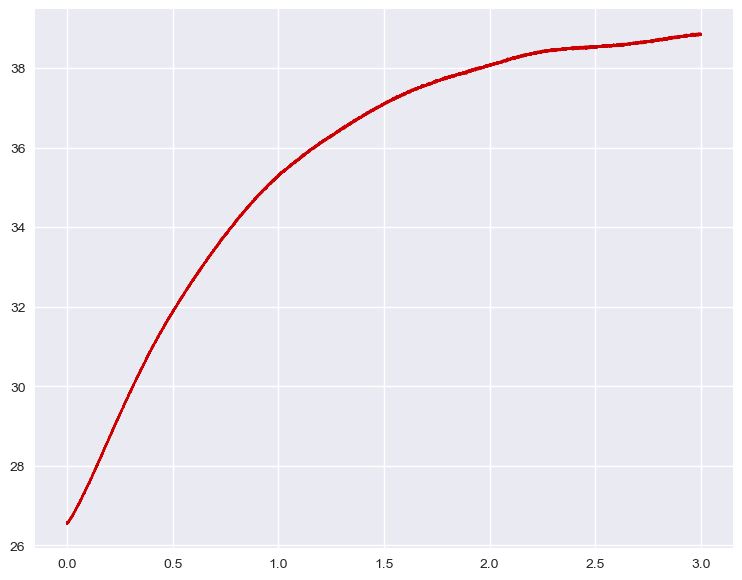

In [156]:
test=filtplot(data_test["CUB21NMC4606_TA_preCheckup.txt"],49,50,plot=1,col=7)


Kapazität bestimmen und Temperaturverläufe

In [ ]:
capacities={}
cccv_dis={}
temperatures={}
for i in data_test.keys():
    temp=filtplot(data_test[i],9,10,plot=0,col=4)
    cap_temp=temp[-1,4]- temp[0,4]
    capacities[i]=abs(cap_temp)
    cccv_dis[i]=temp
    temperatures[i]=np.column_stack((data_test[:,0],data_test[i][:,6], data_test[i][:,7]))

GITT auswerten mit 2RC Fit

In [133]:
lines_dis=[25,26,27]
lines_ch=[36,37,38]
fit_all={}
plot_all={}
hppc_data=[]
IR_all={}
l=0

lines=[lines_dis,lines_ch]
for t in data_test.keys():
    data_t=data_test[t].copy()
    data_t[:,0]=data_t[:,0]*3600
    strome=[]
    for i in range(len(lines)):
        temp=filtplot(data_t,lines[i][1],lines[i][2],plot=0,col=3)
        temp=temp.astype(float)
        temp=consecutive_neu(temp) 
        # for i in range(len(temp)):
        #     temp[i]=process_array(temp[i])
        hppc_data.append(temp)
    plot_data,fit_data,IR_data=[],[],[]
    for i in range(len(lines)):
        plot_temp,fit_temp,strom,IR =hppc_fit_grenzen(data_t,lines[i],0)
        fit_temp=np.vstack([fit_temp])
        plot_data.append(plot_temp)
        fit_data.append(fit_temp)
        IR_data.append(IR)
    plot_all[t]=plot_data
    fit_all[t]=fit_data    
    IR_all[t]=IR_data
    print(t)

CUB21NMC4606_TA_CUage1.txt
CUB21NMC4606_TA_preCheckup.txt
CUB21NMC6001_TA_preCheckup.txt


Parameter plotten

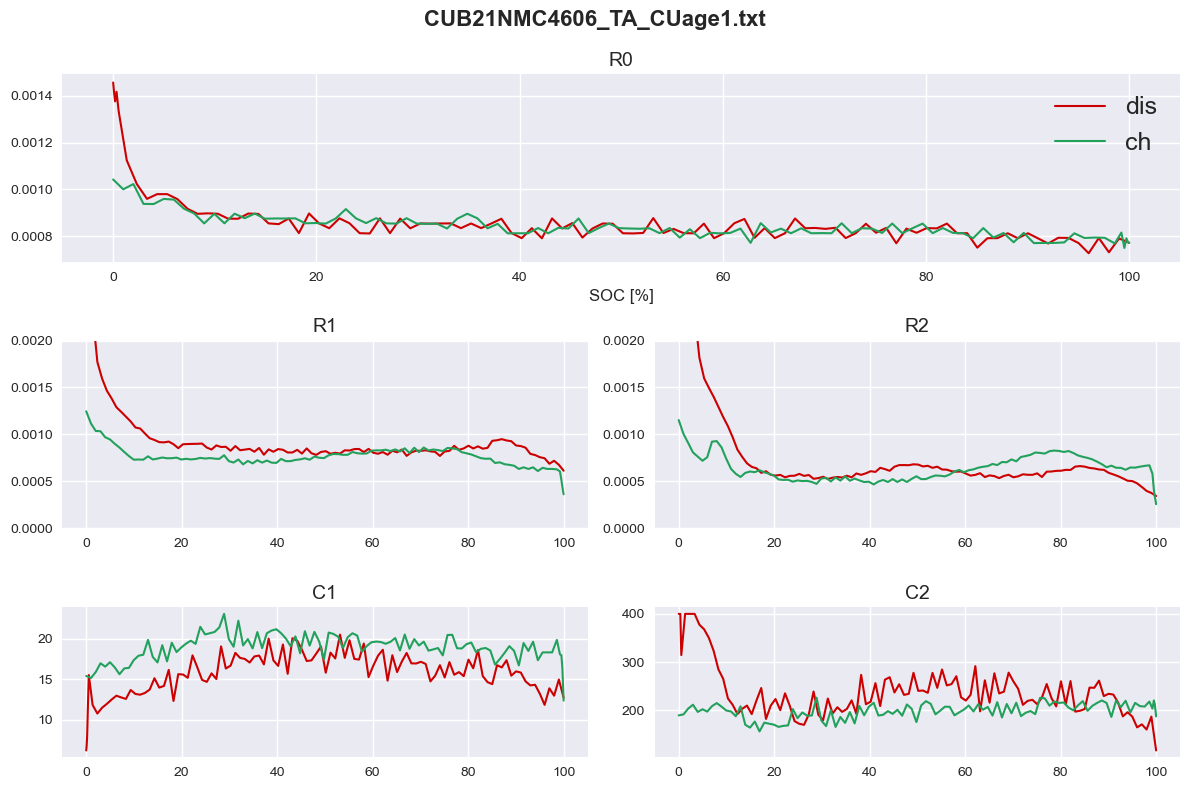

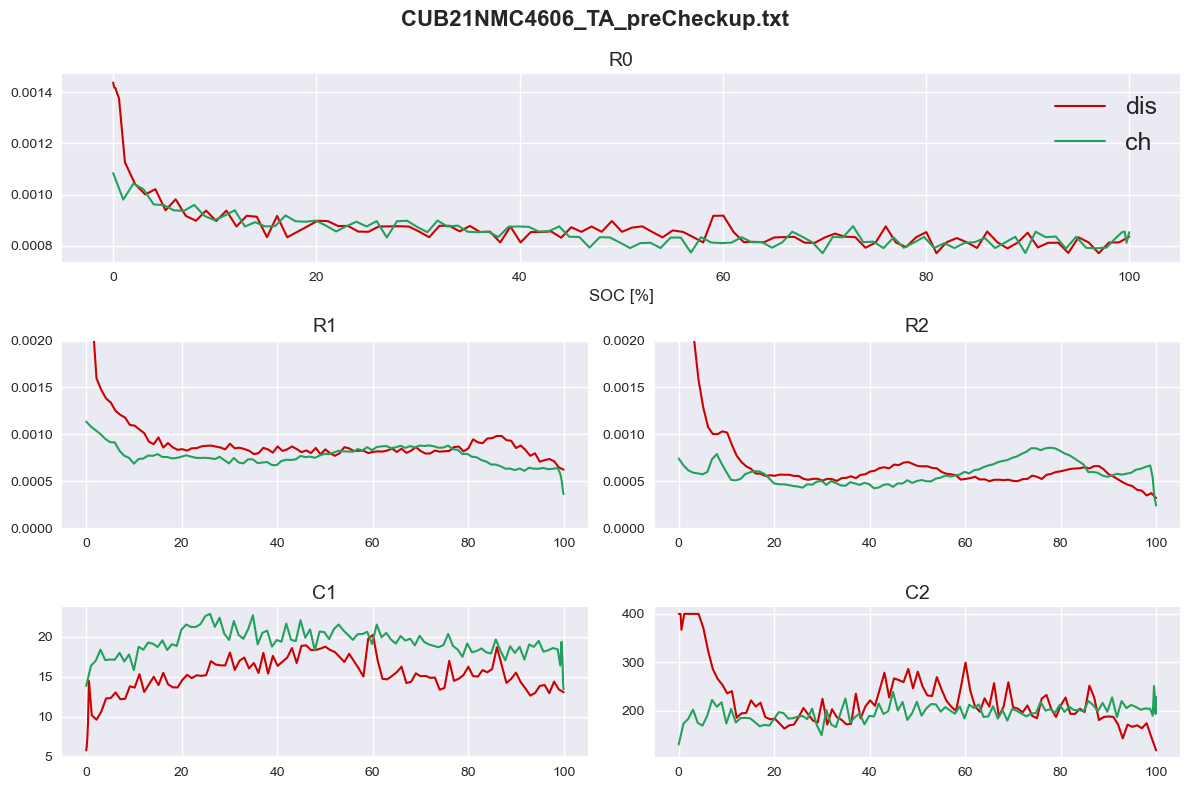

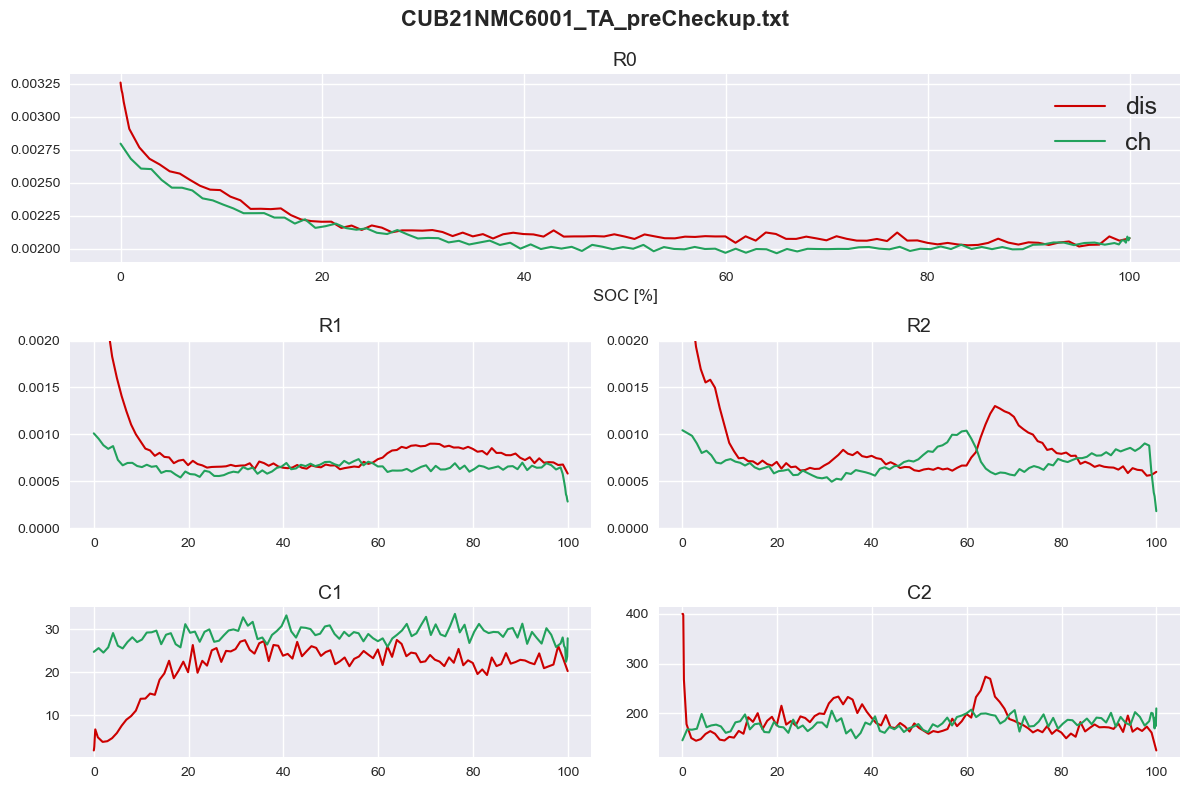

In [134]:
#--------------------------------
#über Spannung oder SOC
xAchse_t="SOC[%]"
# xAchse_t="U[V]"
#-------------------------------

for c in fit_all.keys():
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.8])  # 3 Zeilen, 2 Spalten

    ax00 = fig.add_subplot(gs[0, :])  # obere Reihe
    ax10 = fig.add_subplot(gs[1, 0])  # mitte links
    ax11 = fig.add_subplot(gs[1, 1])  # mitte rechts
    ax20 = fig.add_subplot(gs[2, 0])  # unten links
    ax21 = fig.add_subplot(gs[2, 1])  # unten rechts

    # Plotten
    if xAchse_t=="SOC[%]":
        x_t1=IR_all[c][0][0,:]/IR_all[c][0][0,0]*100
        x_t2=IR_all[c][1][0,:]/IR_all[c][1][0,-1]*100
    elif xAchse_t=="U[V]":
       x_t1=IR_all[c][0][1,:]
       x_t2=IR_all[c][1][1,:]

    ax00.plot(x_t1, fit_all[c][0][1,:], label="dis")
    ax10.plot(x_t1, fit_all[c][0][2,:])
    ax20.plot(x_t1, fit_all[c][0][3,:])
    ax11.plot(x_t1, fit_all[c][0][4,:])
    ax21.plot(x_t1, fit_all[c][0][5,:])

    ax00.plot(x_t2, fit_all[c][1][1,:], label="ch")
    ax10.plot(x_t2, fit_all[c][1][2,:])
    ax20.plot(x_t2, fit_all[c][1][3,:])
    ax11.plot(x_t2, fit_all[c][1][4,:])
    ax21.plot(x_t2, fit_all[c][1][5,:])

    # Achsen Titel
    ax00.set_title("R0",fontsize=14)
    ax10.set_title("R1",fontsize=14)
    ax11.set_title("R2",fontsize=14)
    ax20.set_title("C1",fontsize=14)
    ax21.set_title("C2",fontsize=14)

    # # ylim
    if xAchse_t=="SOC[%]":
        ax10.set_ylim(0, 0.002)
        ax11.set_ylim(0, 0.002)

    # Legende
    ax00.legend()
    ax00.set_xlabel("SOC [%]", fontsize=12)

    # Gesamttitel
    fig.suptitle(c, fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Etwas Platz für den Suptitle
    plt.show()

Fits anschauen

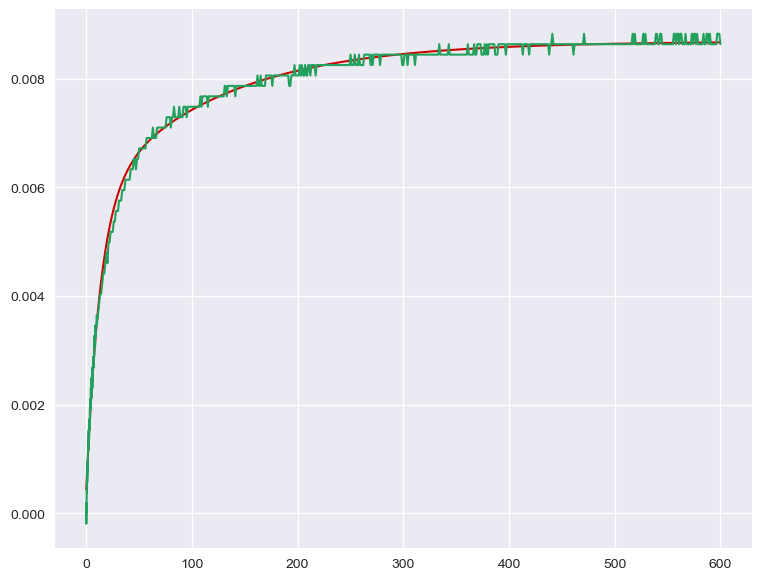

In [138]:
plt.plot(plot_all["CUB21NMC4606_TA_preCheckup.txt"][0][0], label="dis")
plt.plot(hppc_data[2][0][:,0]-hppc_data[2][0][0,0],hppc_data[2][0][:,2]-hppc_data[2][0][0,2])

Temperaturverläufe während Strompulsen am Ende des Tests

CUB21NMC4606_TA_CUage1.txt


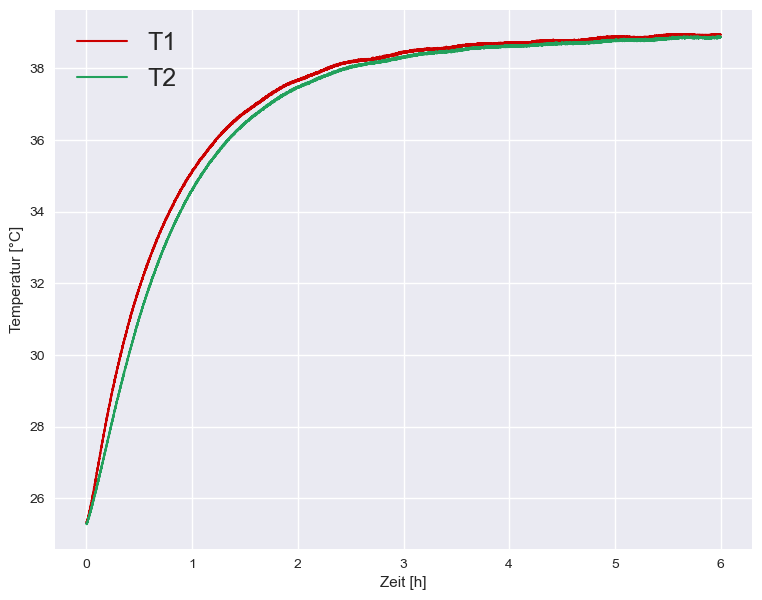

CUB21NMC4606_TA_preCheckup.txt


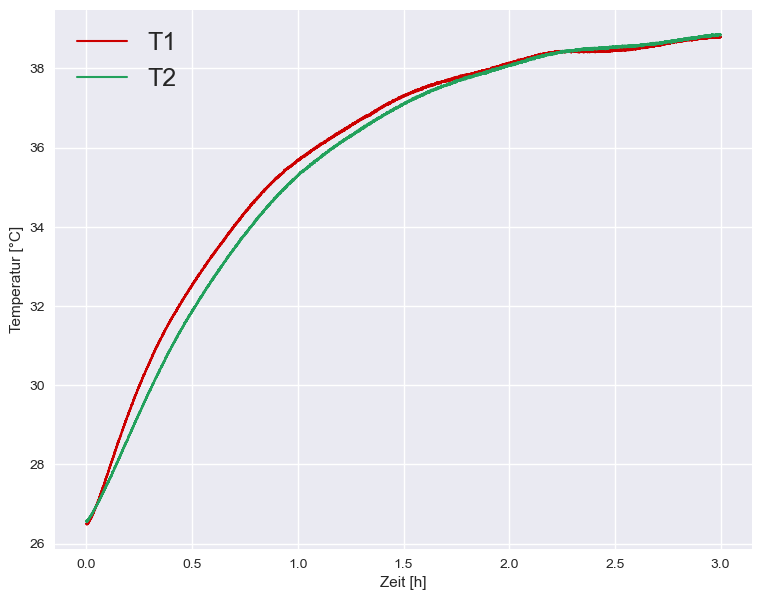

CUB21NMC6001_TA_preCheckup.txt


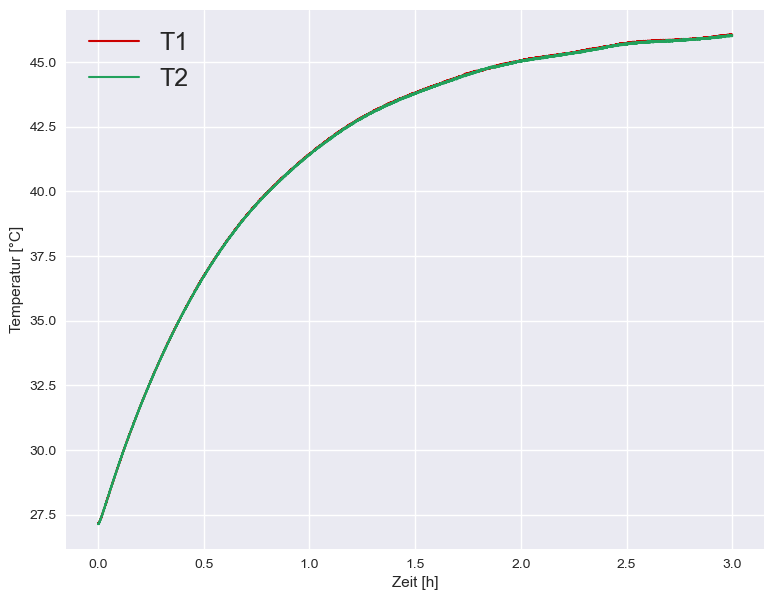

In [158]:
strompulse_data={}
for i in data_test.keys():
    print(i)
    strompulse_temp=filtplot(data_test[i], 49, 50, plot=0, col=7)
    strompulse_data[i]=strompulse_temp
    plt.plot(strompulse_temp[:,0]-strompulse_temp[0,0],strompulse_temp[:,6],label="T1")
    plt.plot(strompulse_temp[:,0]-strompulse_temp[0,0],strompulse_temp[:,7],label="T2")
    plt.xlabel("Zeit [h]")
    plt.ylabel("Temperatur [°C]")
    plt.legend()
    plt.show()
